In [1]:
import numpy as np
import agama
import matplotlib.pyplot as plt

In [13]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 16})

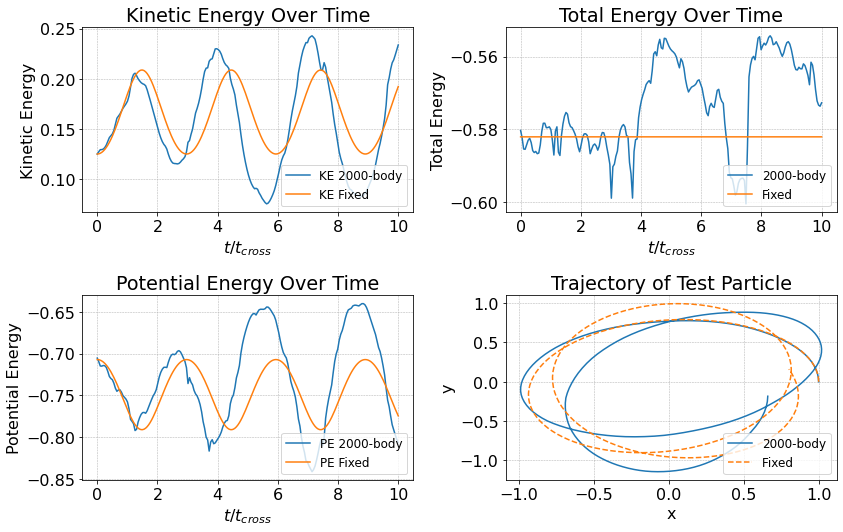

In [27]:
# Parameters

# Number of particles
N = 2000
# Number of crossing times
N_cross = 10           
# Number of time steps
number_of_times = 200 

# Initial conditions for the test particle
x0 = np.array([1.0, 0.0, 0.0])  # Initial position
v0 = np.array([0.0, 0.5, 0.0])  # Initial velocity

# No need to change these
M = 1.0              # Total mass of the globular cluster
R = 1.0                # Scale radius of the Plummer model
G = 1.0                # Gravitational constant (in units where G=1)

# Mass of each particle
m_i = M / N  
epsilon = 0.01  # Softening length (scale radius for Plummer potential)

# Create the Plummer potential and density
pot_plummer = agama.Potential(type='Plummer', mass=M, scaleradius=R)
den_plummer = agama.Density(type='Plummer', mass=M, scaleradius=R)

# Create the distribution function 
df = agama.DistributionFunction(
    type='QuasiSpherical', potential=pot_plummer, density=den_plummer)

# Create the AGAMA GalaxyModel for the chosen potential
model = agama.GalaxyModel(potential=pot_plummer, df=df)

# Sample initial conditions with large N and then keep random sub-sample
Nlarge = int(1e+4)
samples_large, masses = model.sample(Nlarge)
indices = np.random.choice(len(samples_large), size=N, replace=False)
# Use these indices to get the subsets
samples = samples_large[indices]
masses = masses[indices]
# Keep sub-samples
positions = samples[:, :3]    # Initial positions x0
velocities = samples[:, 3:]   # Initial velocities v0

# Compute mean velocity and estimate crossing time
v_mean = np.mean(np.linalg.norm(samples_large[:, 3:] , axis=1))
t_cross = R/v_mean

# Total integration time
T = N_cross * t_cross  

# Keep initial positions and velocities
positions_initial = np.copy(positions)
velocities_initial = np.copy(velocities)

# Combine positions and velocities into initial conditions
ic = np.hstack((positions_initial, velocities_initial))  # Shape (N, 6)

# Integrate orbits using AGAMA's orbit function
orbits = agama.orbit(
    potential=pot_plummer,
    ic=ic,
    time=T,
    trajsize=number_of_times,
    dtype='f8'
)

# Extract the time array and trajectories
times_orbit = orbits[0, 0]  # Time array (same for all particles), shape: (number_of_times,)
trajectories = orbits[:, 1]  # List of arrays of shape (number_of_times, 6), one per particle

# Ensure that 'times_orbit' is a NumPy array
times_orbit = np.array(times_orbit)

# Extract positions and velocities of all particles from trajectories
# Shape (N, number_of_times, 3)
positions_all = np.array([trajectory[:, :3] for trajectory in trajectories])  
velocities_all = np.array([trajectory[:, 3:] for trajectory in trajectories])  
# Create the potential components list
potential_components = []

for i in range(N):
    # Extract positions and velocities for particle i
    positions_i = positions_all[i]  # Shape (number_of_times, 3)
    velocities_i = velocities_all[i]  # Shape (number_of_times, 3)
    
    # Prepare the 'center' array for AGAMA
    # The 'center' array should have columns: time, x, y, z, vx, vy, vz
    # Shape: (number_of_times, 7)
    center_i = np.column_stack((
        times_orbit,                # Time array
        positions_i[:, 0],          # x positions
        positions_i[:, 1],          # y positions
        positions_i[:, 2],          # z positions
        velocities_i[:, 0],         # x velocities
        velocities_i[:, 1],         # y velocities
        velocities_i[:, 2]          # z velocities
    ))
    
    # Define the potential component for particle i
    potential_i = {
        'type': 'plummer',
        'mass': m_i,
        'scaleradius': epsilon,  # Softening length
        'center': center_i
    }
    
    # Append to the list of potential components
    potential_components.append(potential_i)

# Create the composite potential
composite_potential = agama.Potential(*potential_components)

# Pack initial conditions for test particle
ic_test_particle = np.concatenate((x0, v0))  # Shape (6,)

# Integrate the orbit using AGAMA's orbit function
orbit_test_particle = agama.orbit(
    potential=composite_potential,
    ic=ic_test_particle,
    time=T,
    trajsize=number_of_times,
)

# Extract the trajectory of the test particle
times_test_particle = orbit_test_particle[0]  # Time array
trajectory_test_particle = orbit_test_particle[1]  # Shape (number_of_times, 6)

# Extract positions and velocities
positions_test = trajectory_test_particle[:, :3]  # Shape (number_of_times, 3)
velocities_test = trajectory_test_particle[:, 3:]  # Shape (number_of_times, 3)

# Compute kinetic energy of the test particle
speeds_squared = np.sum(velocities_test**2, axis=1)
kinetic_energy_test = 0.5 * speeds_squared

# Compute potential energy of the test particle at each time step
potential_energy_test = np.array([
    composite_potential.potential(positions_test[i], t=times_test_particle[i])
    for i in range(number_of_times)
])

# Compute total energy of the test particle
total_energy_test = kinetic_energy_test + potential_energy_test

# Integrate the orbit in the fixed potential
orbit_test_particle_fixed = agama.orbit(
    potential=pot_plummer,
    ic=ic_test_particle,
    time=T,
    trajsize=number_of_times,
)

# Extract trajectory in fixed potential
times_test_particle_fixed = orbit_test_particle_fixed[0]
trajectory_test_particle_fixed = orbit_test_particle_fixed[1]

# Positions and velocities in fixed potential
positions_test_fixed = trajectory_test_particle_fixed[:, :3]
velocities_test_fixed = trajectory_test_particle_fixed[:, 3:]

# Kinetic energy in fixed potential
speeds_squared_fixed = np.sum(velocities_test_fixed**2, axis=1)
kinetic_energy_test_fixed = N*m_i * 0.5 * speeds_squared_fixed

# Potential energy in fixed potential
potential_energy_test_fixed = N*m_i*pot_plummer.potential(positions_test_fixed)

# Total energy in fixed potential
total_energy_test_fixed = kinetic_energy_test_fixed + potential_energy_test_fixed

#  Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten the 2x2 array into a 1D array for easy indexing

# Plot the trajectory of the test particle in both potentials
i = 3
axes[i].plot(positions_test[:, 0], positions_test[:, 1], label=f'{N}-body')
axes[i].plot(positions_test_fixed[:, 0], positions_test_fixed[:, 1], label='Fixed ', 
             linestyle='--')
axes[i].set_xlabel('x')
axes[i].set_ylabel('y')
axes[i].set_title('Trajectory of Test Particle')
axes[i].legend(loc='lower right', fontsize=12)
axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot the total energy over time for both potentials
i = 1
axes[i].plot(times_test_particle/t_cross, total_energy_test, label=f'{N}-body')
axes[i].plot(times_test_particle_fixed/t_cross, total_energy_test_fixed, label='Fixed')
axes[i].set_xlabel(r'$t/t_{cross}$')
axes[i].set_ylabel('Total Energy')
axes[i].set_title('Total Energy Over Time')
axes[i].legend(loc='lower right', fontsize=12)
axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot kinetic energy over time for both potentials
i = 0
axes[i].plot(times_test_particle/t_cross, kinetic_energy_test, label=f'KE {N}-body')
axes[i].plot(times_test_particle_fixed/t_cross, kinetic_energy_test_fixed, label='KE Fixed')
axes[i].set_xlabel(r'$t/t_{cross}$')
axes[i].set_ylabel('Kinetic Energy')
axes[i].set_title('Kinetic Energy Over Time')
axes[i].legend(loc='lower right', fontsize=12)
axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot potential energy over time for both potentials
i = 2
axes[i].plot(times_test_particle/t_cross, potential_energy_test, label=f'PE {N}-body')
axes[i].plot(times_test_particle_fixed/t_cross, potential_energy_test_fixed, label='PE Fixed')
axes[i].set_xlabel(r'$t/t_{cross}$')
axes[i].set_ylabel('Potential Energy')
axes[i].set_title('Potential Energy Over Time')
axes[i].legend(loc='lower right', fontsize=12)
axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout to make room for the title and labels
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(f"../Figures/nbody_effects_{N}body.png", format="png", dpi=300, 
            facecolor='white', bbox_inches='tight')

plt.show()
